# 状態空間モデルのパラメータ推定(MCMCを中心に)

## MCMCの概要

前回の通り、ベイズの定理を使って、求めたいパラメータの分布は、

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{\sum p(y|\theta)p(\theta)}$$
として求められる。

分母は分子を全て足し合わせた形となっているので、分子$p(y|\theta)p(\theta)$さえ計算できれば良い。

$\theta$が1,2つだと、前回のnotebookのように、範囲を1000個程度の区切って計算すればよいが、時系列分析ではパラメータが100個を超えることも多く、現実的ではない。

MCMCはマルコフ連鎖モンテカルロ法の略で、このような数値計算を効率的に行うことができる。  
"詳細釣り合い条件"と呼ばれるルールに従って、1つ前の値にのみ影響されるような数列(マルコフ連鎖)を作ると、その数列の値の分布が求めたい分布(今回の場合は$p(y|\theta)p(\theta)$)に収束するような数列を作ることができる。

そのようなマルコフ連鎖を作成して、その分布のヒストグラムを算出し、$p(y|\theta)p(\theta)$として代用する方法がMCMCである。

MCMCは今回のような状態空間モデルのみならず、ベイズ推定には広く使用することができるので、MCMCの習得は大変有用である。

## StanとPyStanの使い方

Stanは現状では恐らく、最もドキュメントが充実した確率プログラミング言語である。  
c++に似た記法で、データ、パラメータ、モデル式(確率分布の式)を指定して、走らせると、自動でc++にコンパイルした後、MCMCで分布を計算してくれる。

In [51]:
import pystan

Stanの記法
- 行末には;が必要。
- ブロックは{}で囲む
- コメントは//

### 試しに動かしてみる

In [52]:
# stanコードは文字列で与えることができる。
# dataブロック: パラメータ推定に使用するデータを定義するブロック
# parametersブロック: 推定したいパラメータを定義するブロック
# transformed parameters: 確率分布を含まない、パラメータの計算/式変形を含むブロック
# modelブロック: 正規分布など、確率分布を含むブロック

schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] theta;
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""
# dataは整数型で0以上のJ、長さJの実数のベクトルのy、長さJで0以上の実数のベクトルsigma
# 推定したいパラメータは実数mu、実数で0以上のtau、長さJの実数のベクトルのeta
# 式変形で得られるパラメータは実数で長さJのtheta。thetaはmu + tau * etaで得られる。
# model部分。etaは平均0、標準偏差1の正規分布に、yは平均theta、標準偏差sigmaの正規分布に従う。
# muは平均的な効果、etaは誤差(標準正規分布)、tauは標準偏差、thetaは各々の真のコーチング効果。
# 観測誤差がsigmaである。

In [54]:
# Rubin, 1981 and Gelman, 2003
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4) 
# マルコフ連鎖を4本、1本の数列の長さは1000個であるが、最初の半分はまだ数列が目的の分布に収束していないので、自動で捨てられる

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [55]:
la = fit.extract(permuted=True)  # 結果は辞書の形で得られる。それぞれのパラメータ毎に、マルコフ連鎖がついている

In [56]:
la

OrderedDict([('mu',
              array([ 4.67032318,  7.12541315,  4.14346028, ...,  5.40357963,
                     -4.08537493,  6.07461851])),
             ('tau',
              array([ 0.97194532,  7.0238082 ,  4.46641999, ..., 17.7449538 ,
                      9.9678153 ,  6.10981464])),
             ('eta',
              array([[-0.70989403,  1.55808062, -0.105359  , ..., -0.8419573 ,
                       0.28524002, -0.01547434],
                     [ 1.61929099, -0.86612465, -0.37182991, ..., -0.33920318,
                      -0.3678652 ,  1.47370374],
                     [-0.38067963,  1.36984853, -0.61826941, ..., -0.50005336,
                       0.09645876,  2.05691382],
                     ...,
                     [ 0.62138483,  0.83276367,  0.43289402, ...,  0.24496729,
                       0.76254392,  0.44717218],
                     [-0.3712751 ,  1.10230468, -0.59838919, ..., -0.91277526,
                       1.23516462,  0.91271289],
                

In [57]:
mu = la['mu'] # 各学校のコーチングの平均効果を出す

In [58]:
mu

array([ 4.67032318,  7.12541315,  4.14346028, ...,  5.40357963,
       -4.08537493,  6.07461851])

In [59]:
mu.shape # 1000 / 2 * 4 = 2000個

(2000,)

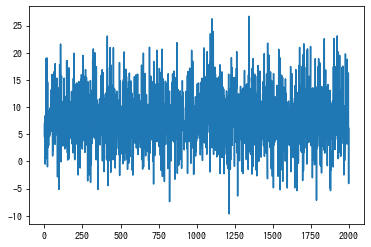

In [61]:
plt.plot(mu)

8.076757980810576


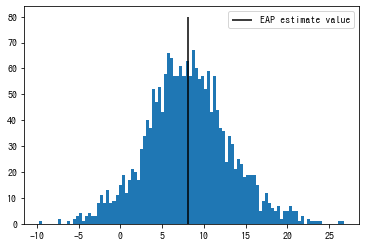

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st

plt.hist(mu, bins=100); # muの分布
plt.vlines(mu.mean(), 0, 80, label = "EAP estimate value")
plt.legend();
print(mu.mean())

全学校の平均的な効果は8前後と推定された。

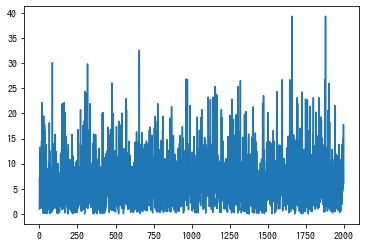

In [62]:
plt.plot(la["tau"])

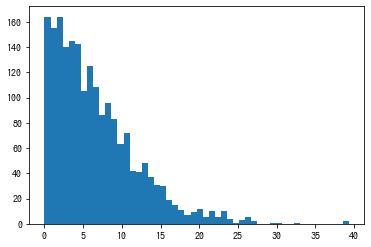

In [64]:
plt.hist(la["tau"], bins=50);

In [65]:
theta = la['theta'] # 各学校のコーチングの真の効果の推定量

In [66]:
theta.shape # 計2000個の数列であるが、変数は8つあるので、2000 x 8のマルコフ連鎖となる

(2000, 8)

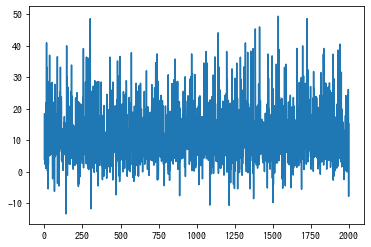

In [67]:
plt.plot(theta[:,0])

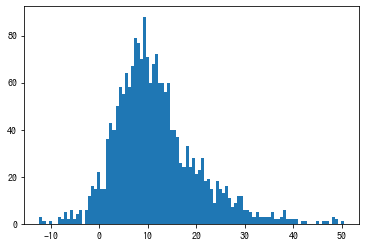

In [27]:
plt.hist(theta[:,0], bins=100); # 1校目

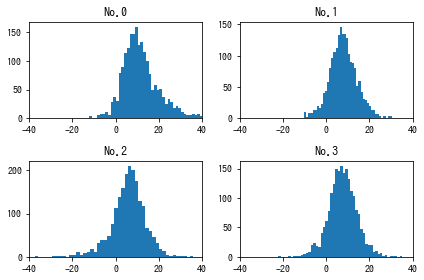

In [32]:
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    plt.hist(theta[:,i], bins=50)
    plt.title(f"No.{i}")# 1校目 ~ 4校目
    plt.xlim(-40, 40)
plt.tight_layout()

### ローカルレベルモデル

In [68]:
model = """data {
  int<lower=1> n;
  int<lower=1> m;
  vector[n] y;
}
parameters {
  vector[n] mu;
  real<lower=0> sigma_level;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
}
model {
  for(t in 2:n)
  {
    mu[t] ~ normal(mu[t-1], sigma_level);
    y ~ normal(mu[t], sigma_irreg);
  }
}
generated quantities {
    vector[n+m] mu_pred;
    vector[n+m] y_pred;
    mu_pred[1:n] = mu;
    y_pred[1:n] = y;

    for (t in 1:m) {
        mu_pred[n+t] = normal_rng(mu_pred[n+t-1], sigma_level);
        y_pred[n+t] = normal_rng(mu_pred[n+t], sigma_irreg);
    }
}
"""

In [69]:
dat_local = {'n': 11,
             'm': 5,
             'y': [10.06097469, 10.40798098, 10.52350358, 10.3303128 , 11.45294242,
                   11.63782415, 11.3387652 , 12.84233771, 13.0128606 , 12.53294464,
                   13.77612241]}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat_local, iter=1000, chains=4) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3749ff593660f5ddeaf5ea4a4933b091 NOW.


In [70]:
la = fit.extract(permuted=True)  # 結果は辞書の形で得られる。それぞれのパラメータ毎に、マルコフ連鎖がついている

In [82]:
la

OrderedDict([('mu',
              array([[11.94423009, 11.85355772, 11.81481637, ..., 11.60437495,
                      11.70661891, 11.70904005],
                     [12.23273862, 12.13235193, 12.04748692, ..., 11.57450147,
                      11.61206778, 11.67017893],
                     [11.48563832, 11.73939539, 11.6052761 , ..., 11.32492025,
                      11.22674889, 11.34482251],
                     ...,
                     [11.94758356, 11.93909604, 11.91481468, ..., 11.91204106,
                      11.91662825, 11.91202358],
                     [11.25165809, 11.49624458, 11.37321103, ..., 12.0172356 ,
                      11.71652088, 11.92139199],
                     [11.67387698, 11.66608274, 11.59788182, ..., 11.73964917,
                      11.73703569, 11.81885383]])),
             ('sigma_level',
              array([0.08971601, 0.11851338, 0.21060221, ..., 0.0311102 , 0.20068743,
                     0.0567815 ])),
             ('sigma_irreg',
   

In [73]:
mu = ala["mu"]

In [74]:
mu.shape

(2000, 11)

In [80]:
mu.mean(axis=0)

array([11.64437088, 11.64215836, 11.64318581, 11.6441556 , 11.64116432,
       11.64550111, 11.64301807, 11.64511944, 11.63801292, 11.63804183,
       11.63610033])

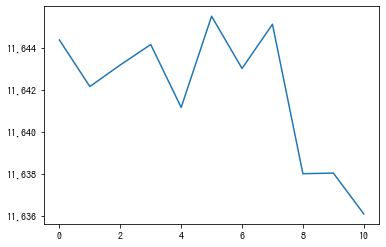

In [81]:
plt.plot(mu.mean(axis=0))

In [ ]:
# sigma_level
# sigma_irreg